# Whittle- Matérn prior

The aim of this notebook is to show simulation of the Whittle-Matérn priors described in the paper 

*Calvetti and Somersalo (2017) Inverse problems: From regularization to Bayesian inference*



sent by Thomas

In [21]:
# Install the geostatistical package "gstlearn" (developped by our team)
# It is stored on incubator of python packages, so you have to uncomment the next line

# !pip install -i https://test.pypi.org/simple/ gstlearn

In [22]:
# !git clone git://github.com/scikit-sparse/scikit-sparse.git
# !sudo apt-get install python-scipy libsuitesparse-dev
# !pip install --user scikit-sparse

In [1]:
import gstlearn as gl
# import gstlearn.plot as gp

#sksparse is a little bit tricky to install
from sksparse.cholmod import cholesky

#common packages
import scipy as sc
from scipy.sparse import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate(ranges = [5,10], variance = 10, param = 1, nx = [100,100],mu=2500):
    #Creation of the covariance model (Whittle-Matérn prior)
    model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param = param,
                                     sill = variance, ranges = ranges)
    
    #Creation of the grid 
    mesh = gl.MeshETurbo(nx)
    
    #Creation of the precision matrix (inverse of the covariance)
    precisionOpMat = gl.PrecisionOpCs(mesh,model,0,gl.EPowerPT.ONE,False)
    Qtr = gl.csToTriplet(precisionOpMat.getQ())
    Qmat = sc.sparse.csc_matrix((np.array(Qtr.values), (np.array(Qtr.rows), np.array(Qtr.cols))))
    
    #Cholesky decomposition
    cholQ = cholesky(Qmat)
    
    #Random vector
    u = np.random.normal(size=np.prod(Qmat.shape[0]))
    
    # Apply the inverse of the Cholesky decomposition
    
    simu = cholQ.apply_Pt(cholQ.solve_DLt(u))
    
    #Return the simulation (reshaped)
    
    return simu.reshape(mesh.getGrid().getNXs())+mu, Qmat

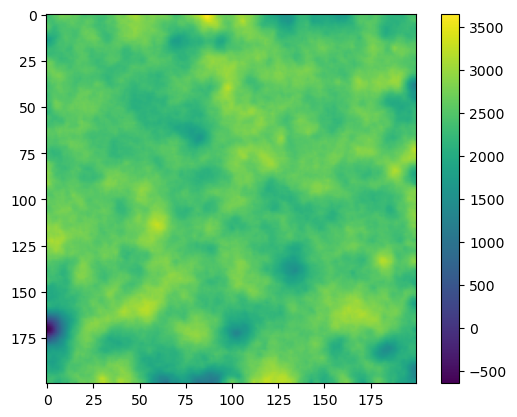

In [3]:
mu=2500
nz,nx = 200,200
simu, Q = simulate(ranges = [20,20],param=1,nx=[nz,nx],variance=500,mu=mu)
plt.imshow(simu)
a=plt.colorbar()

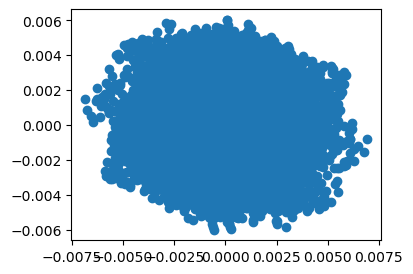

In [4]:
from sklearn.decomposition import PCA
# Create a precision matrix for the prior distribution
precision_matrix = Q.toarray()

# Perform PCA on the precision matrix
pca = PCA(n_components=2)
pc = pca.fit_transform(precision_matrix)

# Plot the first two principal components
plt.figure(figsize=(4,3))
plt.scatter(pc[:, 0], pc[:, 1])
plt.show()

In [ ]:
np.random.normal(scale=proposal_sigma, size=state.shape)

## To do 

Play with the parameters **ranges** (use different values for the two components), **variance** and **param** (which has to be an integer)

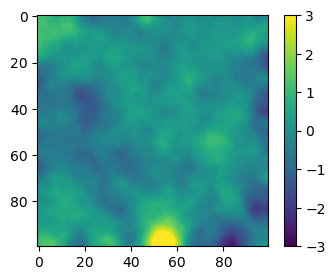

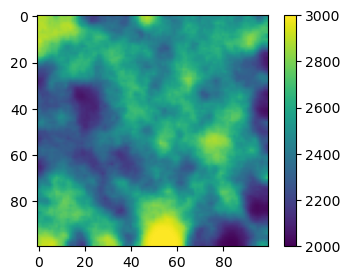

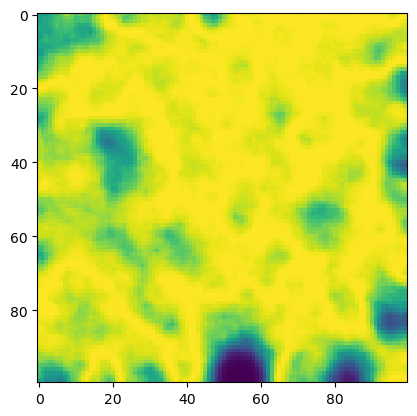

In [35]:
u = np.zeros([nz, nx])
u, _ = simulate(ranges = [20,20],param=1,nx=[nz,nx],variance=1,mu=0)
plt.figure(figsize=(4,3))
plt.imshow(u,vmin=-3,vmax=3)
plt.colorbar()
plt.show()

plt.figure(figsize=(4,3))
def f(u, vmin=2000, vmax=3000):
    # cdf of gaussian
    cdf = sc.stats.norm.cdf(u, loc=0, scale=1)
    v = (vmax-vmin)*cdf + vmin
    # # tanh
    # v = 500*np.tanh(u) + 2500
    # # sigmoid
    # sigmoid = 1/(1+np.exp(-u))
    # v = (vmax-vmin)*sigmoid + vmin

    return v.reshape((nz,nx))

v = f(u.flatten())
plt.imshow(v.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.show()

df = sc.misc.derivative(f,u)
# plt.imshow(df.reshape((nz,nx)))

# Creat a velocity field using 2 gaussian

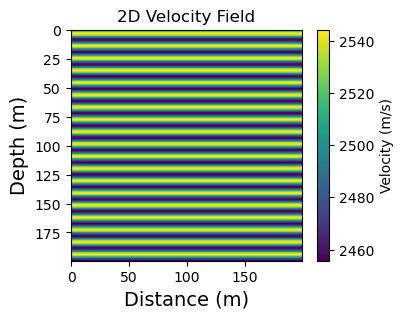

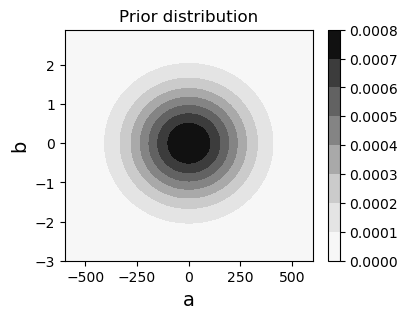

In [318]:
labelsize=14
from scipy.stats import multivariate_normal
mu_a, std_a = 0, 200
mu_b, std_b = 0, 1
# Define the mean and covariance matrix
mu = np.array([mu_a, mu_b])
cov = np.array([[std_a**2, 0], [0, std_b**2]])
Q = np.linalg.inv(cov)

a = np.random.normal(mu_a, std_a)
b = np.random.normal(mu_b, std_b)

x, z = np.meshgrid(np.arange(200), np.arange(200))
v = 2500 + a * np.sin(b*z)
# v = 2500 + a + z * b**2
plt.figure(figsize=(4,3))
plt.imshow(v)
plt.title("2D Velocity Field")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.show()

# Create a grid of points to evaluate the distribution at
# x, y = np.mgrid[-3:3:.1, -3:3:.1]
xx, yy = np.mgrid[mu_a-3*std_a:mu_a+3*std_a:.1, mu_b-3*std_b:mu_b+3*std_b:.1]
pos = np.dstack((xx, yy))

# Evaluate the distribution at each point in the grid
rv = multivariate_normal(mu, cov)
zz = rv.pdf(pos)

# Plot the distribution
plt.figure(figsize=(4,3))
plt.contourf(xx, yy, zz, cmap='Greys')
plt.title("Prior distribution")
plt.xlabel('a', fontsize=labelsize)
plt.ylabel('b', fontsize=labelsize)
plt.colorbar()
plt.show()

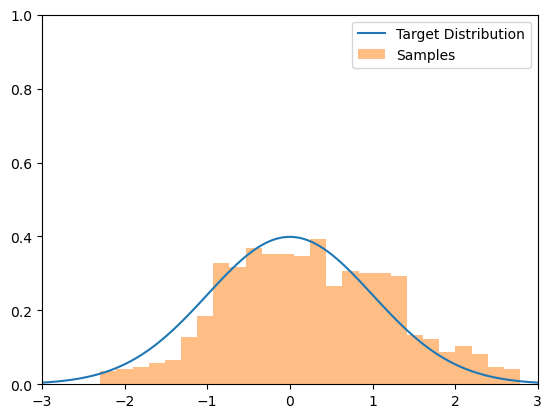

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the target distribution (i.e. posterior)
def target_dist(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

# Define the proposal distribution (i.e. normal distribution)
def proposal_dist(x, sigma):
    return np.random.normal(x, sigma)

# Define the MCMC sampling function
def MCMC_sampling(num_samples, sigma):
    samples = np.zeros(num_samples)
    current_sample = np.random.normal(0, 1)
    for i in range(num_samples):
        # Compute the current probability
        current_prob = target_dist(current_sample)
        
        # Propose a new sample
        proposed_sample = proposal_dist(current_sample, sigma)
        
        # Compute the proposal probability
        proposal_prob = target_dist(proposed_sample)
        
        # Compute the acceptance probability
        alpha = min(1, proposal_prob/current_prob)
        
        # Accept or reject the proposal
        if np.random.rand() < alpha:
            current_sample = proposed_sample
        samples[i] = current_sample
    return samples

# Set the parameters
num_samples = 1000
sigma = 0.5

# Generate the samples using MCMC
samples = MCMC_sampling(num_samples, sigma)

# Plot the results
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.set_ylim(0, 1)

x = np.linspace(-3, 3, 100)
ax.plot(x, target_dist(x), label='Target Distribution')
ax.hist(samples, bins=30, density=True, alpha=0.5, label='Samples')

ax.legend()

# Define the animation function
def animate(i):
    ax.cla()
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 1)

    x = np.linspace(-3, 3, 100)
    ax.plot(x, target_dist(x), label='Target Distribution')
    ax.hist(samples[:i], bins=30, density=True, alpha=0.5, label='Samples')

    ax.legend()

# Animate the iterations
ani = FuncAnimation(fig, animate, frames=num_samples, interval=10, repeat=False)
plt.show()


/tmp/ipykernel_9134/4134578909.py:5: RuntimeWarning: divide by zero encountered in log
  u = np.log(v-a)-np.log(b-v)


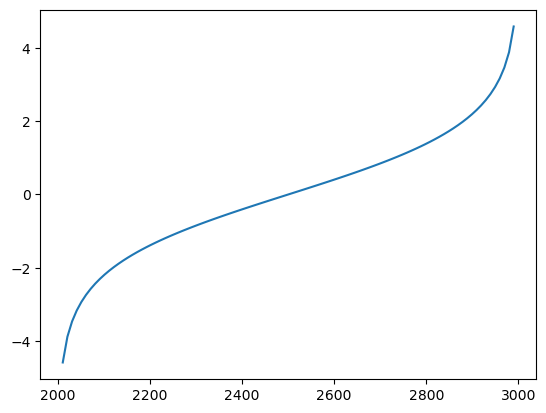

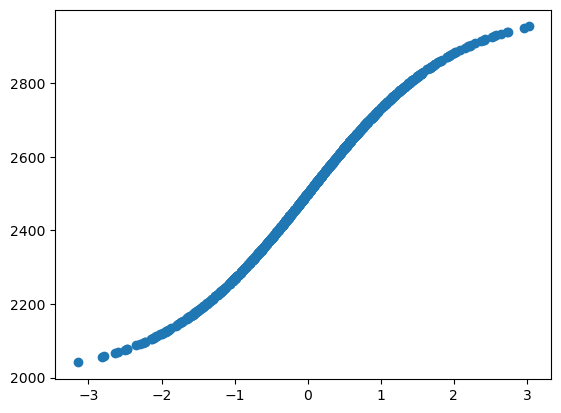

In [19]:
import numpy as np
import matplotlib.pyplot as plt
v = np.linspace(2000,3000,100)
a, b = 2000, 3000
u = np.log(v-a)-np.log(b-v)
plt.plot(v,u)
plt.show()

# u = np.linspace(-10,10,100)
u = np.random.normal(0,1,1000)
v = a+(b-a)/(1+np.exp(-u))
plt.scatter(u,v)
plt.show()